In [ ]:
!pip install --upgrade google-cloud-bigquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.34.0
    Uninstalling google-cloud-bigquery-3.34.0:
      Successfully uninstalled google-cloud-bigquery-3.34.0


In [5]:
from google.colab import auth
auth.authenticate_user()

In [7]:
from google.cloud import bigquery

# Replace 'mineral-effect-235218' with your actual Google Cloud project ID
client = bigquery.Client(project='mineral-effect-235218')

query = """
WITH funnel_events AS (
  SELECT
    user_pseudo_id,
    event_name,
    event_timestamp,
    PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS event_date
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20201101' AND '20201130'
    AND event_name IN (
      'session_start', 'view_item', 'add_to_cart', 'begin_checkout', 'purchase'
    )
),

user_funnel AS (
  SELECT
    user_pseudo_id,
    MAX(IF(event_name = 'session_start', 1, 0)) AS session_start,
    MAX(IF(event_name = 'view_item', 1, 0)) AS view_item,
    MAX(IF(event_name = 'add_to_cart', 1, 0)) AS add_to_cart,
    MAX(IF(event_name = 'begin_checkout', 1, 0)) AS begin_checkout,
    MAX(IF(event_name = 'purchase', 1, 0)) AS purchase
  FROM
    funnel_events
  GROUP BY
    user_pseudo_id
)

SELECT
  COUNT(*) AS total_users,
  SUM(session_start) AS sessions,
  SUM(view_item) AS product_views,
  SUM(add_to_cart) AS add_to_cart,
  SUM(begin_checkout) AS checkout_started,
  SUM(purchase) AS purchases
FROM
  user_funnel;
"""

query_job = client.query(query)
results = query_job.to_dataframe()
results

,total_users,sessions,product_views,add_to_cart,checkout_started,purchases
0,78738,78383,21440,2060,4219,1532


In [8]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   total_users       1 non-null      Int64
 1   sessions          1 non-null      Int64
 2   product_views     1 non-null      Int64
 3   add_to_cart       1 non-null      Int64
 4   checkout_started  1 non-null      Int64
 5   purchases         1 non-null      Int64
dtypes: Int64(6)
memory usage: 186.0 bytes


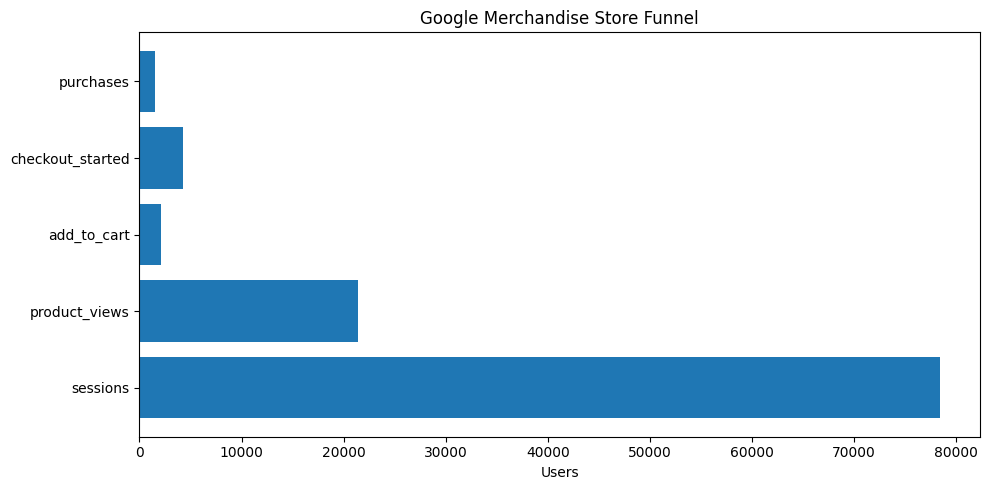

In [9]:
import matplotlib.pyplot as plt

stages = [
    "sessions", "product_views", "add_to_cart",
    "checkout_started", "purchases"
]
values = [int(results[col][0]) for col in stages]

plt.figure(figsize=(10, 5))
plt.barh(stages[::-1], values[::-1])
plt.xlabel("Users")
plt.title("Google Merchandise Store Funnel")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [10]:
for i in range(1, len(values)):
    print(f"{stages[i]}: {round(values[i] / values[i-1] * 100, 2)}%")


product_views: 27.35%
add_to_cart: 9.61%
checkout_started: 204.81%
purchases: 36.31%


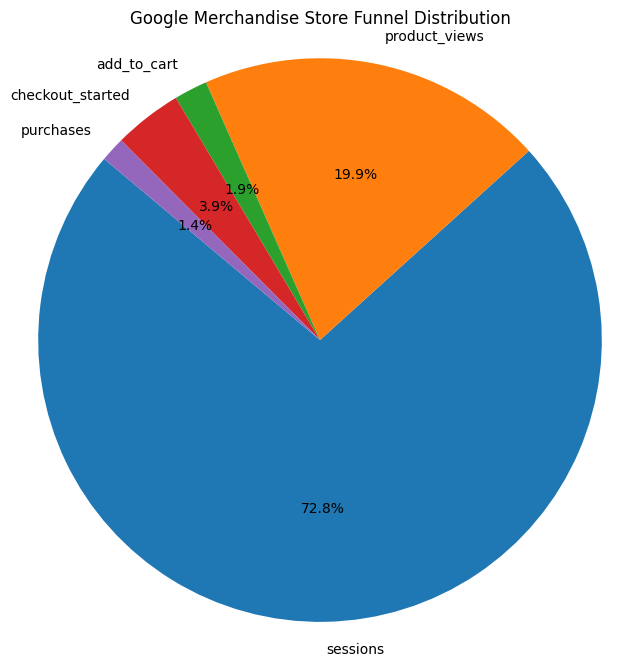

In [11]:
# prompt: plot the above  using pie chart

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.pie(values, labels=stages, autopct='%1.1f%%', startangle=140)
plt.title("Google Merchandise Store Funnel Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [12]:
results.to_csv("funnel_results.csv", index=False)


In [13]:
category_funnel_query = """
WITH item_events AS (
  SELECT
    event_name,
    user_pseudo_id,
    PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS event_date,
    item.item_category AS category
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`,
    UNNEST(items) AS item
  WHERE
    _TABLE_SUFFIX BETWEEN '20201101' AND '20201130'
    AND event_name IN ('view_item', 'add_to_cart', 'purchase')
),

category_funnel AS (
  SELECT
    category,
    COUNTIF(event_name = 'view_item') AS views,
    COUNTIF(event_name = 'add_to_cart') AS add_to_cart,
    COUNTIF(event_name = 'purchase') AS purchases
  FROM
    item_events
  WHERE category IS NOT NULL
  GROUP BY category
)

SELECT
  category,
  views,
  add_to_cart,
  purchases,
  ROUND(SAFE_DIVIDE(add_to_cart, views) * 100, 2) AS view_to_cart_rate,
  ROUND(SAFE_DIVIDE(purchases, add_to_cart) * 100, 2) AS cart_to_purchase_rate,
  ROUND(SAFE_DIVIDE(purchases, views) * 100, 2) AS view_to_purchase_rate
FROM category_funnel
ORDER BY view_to_purchase_rate ASC
"""


In [14]:
category_job = client.query(category_funnel_query)
category_results = category_job.to_dataframe()
category_results.head()


,category,views,add_to_cart,purchases,view_to_cart_rate,cart_to_purchase_rate,view_to_purchase_rate
0,Uncategorized Items,0,0,296,NaN,NaN,NaN
1,Writing Instruments,0,0,67,NaN,NaN,NaN
2,Fun,0,0,31,NaN,NaN,NaN
3,Black Lives Matter,0,0,1,NaN,NaN,NaN
4,Clearance,0,0,241,NaN,NaN,NaN


In [15]:
from google.cloud import bigquery

# Replace 'mineral-effect-235218' with your actual Google Cloud project ID
client = bigquery.Client(project='mineral-effect-235218')

category_job = client.query(category_funnel_query)
category_results = category_job.to_dataframe()
category_results.head()

,category,views,add_to_cart,purchases,view_to_cart_rate,cart_to_purchase_rate,view_to_purchase_rate
0,Clearance,0,0,241,NaN,NaN,NaN
1,Notebooks & Journals,0,0,26,NaN,NaN,NaN
2,(not set),0,15,54,NaN,360.0,NaN
3,Electronics Accessories,0,0,23,NaN,NaN,NaN
4,Gift Cards,0,0,1,NaN,NaN,NaN


/tmp/ipython-input-17-1580589979.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


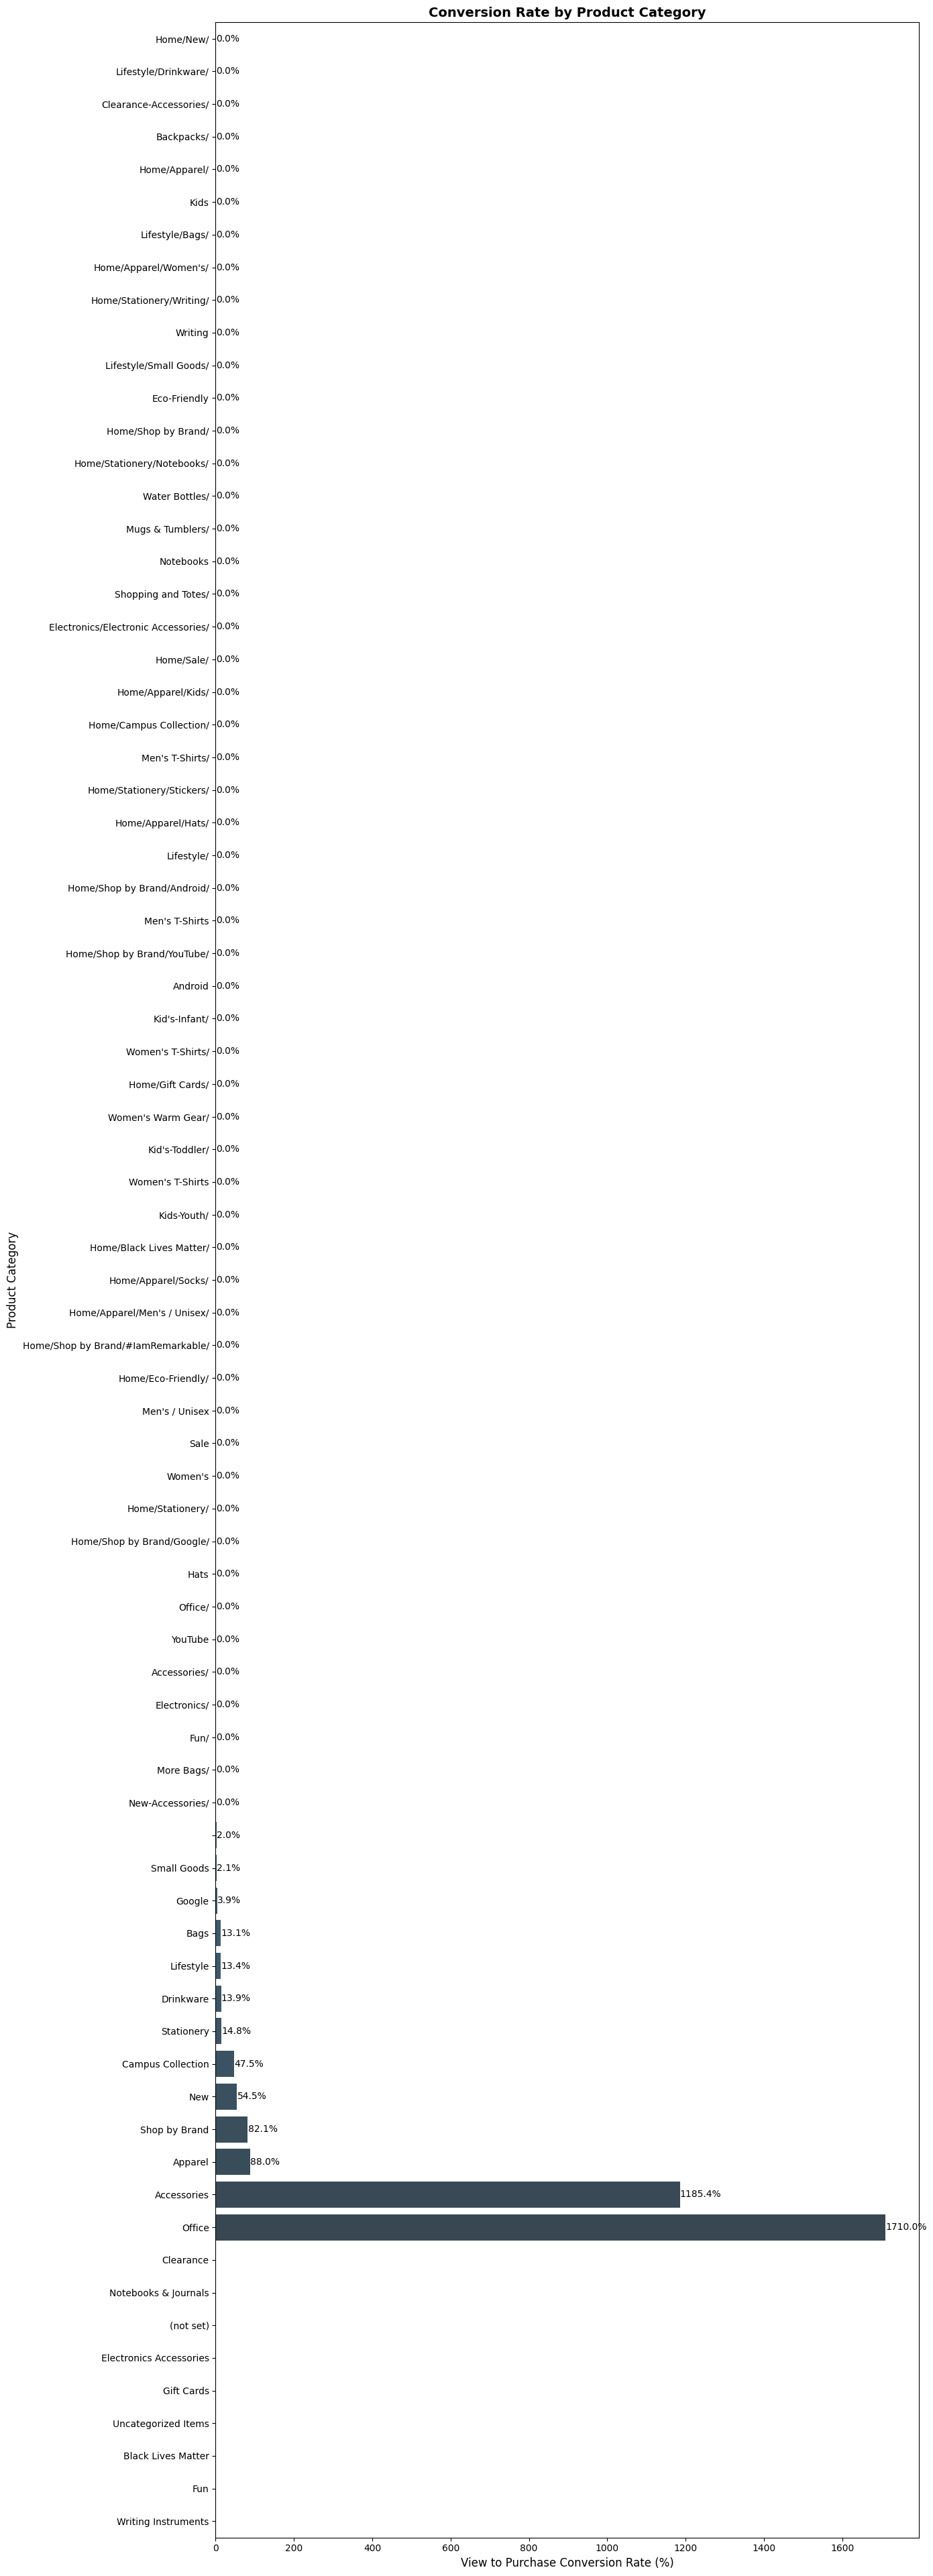

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by conversion rate
sorted_df = category_results.sort_values(by='view_to_purchase_rate', ascending=True)

# Set up the figure with more vertical space
plt.figure(figsize=(14, max(6, 0.5 * len(sorted_df))))  # dynamic height based on number of categories

# Plot bar chart
sns.barplot(
    data=sorted_df,
    x='view_to_purchase_rate',
    y='category',
    palette='Blues_d'
)

# Set labels and title
plt.xlabel("View to Purchase Conversion Rate (%)", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.title("Conversion Rate by Product Category", fontsize=14, weight='bold')

# Add percentage labels on bars
for index, value in enumerate(sorted_df['view_to_purchase_rate']):
    plt.text(value + 0.5, index, f"{value:.1f}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [19]:
# Export overall funnel
results.to_csv("overall_funnel.csv", index=False)

# Export category-wise funnel
category_results.to_csv("category_funnel.csv", index=False)